In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with = engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
inspector = inspect(engine)

In [10]:
measurement_columns = inspector.get_columns('measurement')
station_columns = inspector.get_columns('station')

In [11]:
for column in measurement_columns:
    print(column["name"],column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
for column in station_columns:
    print(column["name"],column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
end_date = dt.date(2017,8,23)
start_date = end_date - dt.timedelta(days = 365)

In [15]:
# Perform a query to retrieve the data and precipitation scores

measurements = session.query(Measurement).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date)

dates = []
precipitations = []

for measurement in measurements:
    dates.append(measurement.date)
    precipitations.append(measurement.prcp)

In [16]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names

measurements_df = pd.DataFrame(dates)
measurements_df = measurements_df.rename(columns = {0 : "date"})
measurements_df["precipitation"] = precipitations
measurements_df = measurements_df.sort_values("date")

measurements_df.head()

,date,precipitation
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15


Text(0, 0.5, 'Precipitation Inches')

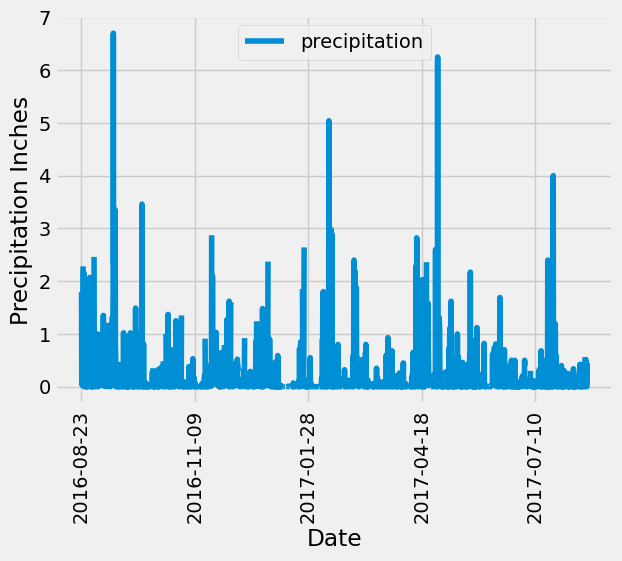

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data
measurements_df.plot(x = "date", y = "precipitation", rot = 90)
plt.xlabel("Date")
plt.ylabel("Precipitation Inches")

In [18]:
# Use Pandas to calculate the summary statistics for the precipitation data
measurements_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [19]:
# Design a query to calculate the total number of stations in the dataset
station_count = session.query(Station.name).distinct().count()
station_count

9

In [20]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
stations = []
precipitations = []

active_stations = session.query(Measurement)
for active_station in active_stations:
    stations.append(active_station.station)
    precipitations.append(active_station.prcp)
    
active_stations_df = pd.DataFrame(stations)
active_stations_df = active_stations_df.rename(columns = {0 : "stations"})
active_stations_df["precipitation"] = precipitations

In [21]:
# List the stations and their counts in descending order.
grouped_df = active_stations_df.groupby(active_stations_df["stations"]).count()
grouped_df = grouped_df.sort_values("precipitation", ascending = False)
grouped_df

,precipitation
stations,
USC00519281,2772
USC00513117,2696
USC00519397,2685
USC00519523,2572
USC00516128,2484
USC00514830,1937
USC00511918,1932
USC00517948,683
USC00518838,342


In [22]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

active_station_temperatures = session.query(Measurement).\
    filter(Measurement.station == 'USC00519281')

temperatures = []
for temperature in active_station_temperatures:
    temperatures.append(temperature.tobs)
    
temp_df = pd.DataFrame(temperatures)
temp_df = temp_df.rename(columns = {0 : "temperature"})

min_temp = temp_df["temperature"].min()
max_temp = temp_df["temperature"].max()
mean_temp = temp_df["temperature"].mean()

In [23]:
min_temp

54.0

In [24]:
max_temp

85.0

In [25]:
mean_temp

71.66378066378067

In [26]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station

last_year_temperatures = session.query(Measurement).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date)


last_yr_temperatures = []
for temperature in last_year_temperatures:
    last_yr_temperatures.append(temperature.tobs)
    
last_yr_temp_df = pd.DataFrame(last_yr_temperatures)
last_yr_temp_df = temp_df.rename(columns = {0 : "temperature"})

last_yr_temp_df.head()

,temperature
0,70.0
1,62.0
2,74.0
3,75.0
4,74.0


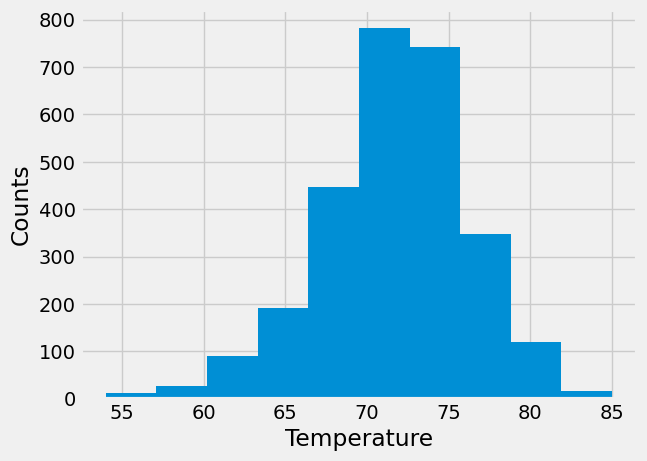

In [27]:
# Plot the results as a histogram
series = last_yr_temp_df["temperature"]
plt.hist(series)
plt.xlabel("Temperature")
plt.ylabel("Counts")
plt.show()

# Close Session

In [28]:
# Close Session
session.close()

# Flask API


In [ ]:
# Import the dependencies.
import datetime as dt
import numpy as np
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from flask import Flask, jsonify

#################################################
# Database Setup
#################################################
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine)


# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

# Create our session (link) from Python to the DB
session = Session(engine)

#################################################
# Flask Setup
#################################################
app = Flask(__name__)


#################################################
# Flask Routes
# Setup and query structure are partly borrowed from Drew's speed run
#################################################

@app.route("/")
def welcome():
   #List all available API routes
   return(
       f"Available routes:<br/>"
       f"/api/v1.0/precipitation<br/>"
       f"/api/v1.0/stations<br/>"
       f"/api/v1.0/tobs<br/>"
       f"/api/v1.0/start<br/>"
       f"/api/v1.0/start/end"
   )


@app.route("/api/v1.0/precipitation")
def precipitation():

   #Query the precipitation data
   end_date = dt.date(2017,8,23)
   start_date = dt.date(2016,8,23)
  
   precipitation_results = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= start_date).\
        filter(Measurement.date <= end_date)

   session.close()

   # Create a dictionary of precipitation data and append to a list
   precipitation_data = []
   for date, prcp in precipitation_results:
       precipitation_dict = {}
       precipitation_dict["date"] = date
       precipitation_dict["precipitation"] = prcp
       precipitation_data.append(precipitation_dict)


   return jsonify(precipitation_data)



@app.route("/api/v1.0/stations")
def stations():

   #Query the station data
   station_results = session.query(Station.name).all()

   session.close()

   # Create a list of station data
   station_data = list(np.ravel(station_results))
   
   return jsonify(station_data = station_data)



@app.route("/api/v1.0/tobs")
def tobs():

   #Query the temperature data
   start_date = dt.date(2016,8,23)
   temperature_results = session.query(Measurement.tobs).\
      filter(Measurement.station == 'USC00519281').\
      filter(Measurement.date >= start_date).all()
   
   session.close()

   # Create list of temperature data
   temperature_data = list(np.ravel(temperature_results))

   return(jsonify(temperature_data = temperature_data))


@app.route("/api/v1.0/<start>")
@app.route("/api/v1.0/<start>/<end>")
def stats (start = None, end = None):

   min_avg_max_function = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]

   if not end:
      start = dt.datetime.strptime(start, "%m%d%Y")
      start_results = session.query(*min_avg_max_function).\
         filter(Measurement.date >= start).all()

      session.close()
      
      start_data = list(np.ravel(start_results))
      return(jsonify(start_data = start_data))
   
   start = dt.datetime.strptime(start, "%m%d%Y")
   end = dt.datetime.strptime(end,"%m%d%Y")

   start_end_results = session.query(*min_avg_max_function).\
      filter(Measurement.date >= start).\
      filter(Measurement.date <= end).all()
   
   session.close()

   start_end_data = list(np.ravel(start_end_results))
   return jsonify (start_end_data = start_end_data)

###

if __name__ == "__main__":
   app.run(debug=True)